In [1]:
from camera.camera import Camera
from lane_finder.lanefinder import Lanefinder
from imageprocessor.imageprocessor import Imageprocessor

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
cam = Camera("camera1",config_folder = "camera/camera_config")
if cam.is_calibrated == False:
    cam.calibrate_and_draw("camera_cal/", 9, 6)

Initializing camera ...
Found config file ...
Loading configuration for camera ...
Done ...


In [3]:
imageprocessor = Imageprocessor()
# Set perspective transform
image_top_left = (580,458)
image_top_right = (703,458)
image_bottom_left = (252, 678)
image_bottom_right = (1054,678)

birdeye_top_left = (400,20)
birdeye_top_right = (890,20)
birdeye_bottom_left = (400, 700)
birdeye_bottom_right = (890,700)

src = np.float32([image_top_left,image_bottom_left,image_top_right,image_bottom_right])
dst = np.float32([birdeye_top_left,birdeye_bottom_left,birdeye_top_right,birdeye_bottom_right])
imageprocessor.set_perspective_transform(src,dst)



Initializing image processor ..
Done ...


(array([[ -3.79681744e-01,  -1.52267172e+00,   8.79475912e+02],
        [ -5.27355937e-15,  -1.96863927e+00,   8.99730630e+02],
        [ -8.78203760e-18,  -2.39150189e-03,   1.00000000e+00]]),
 array([[  2.44921619e-01,  -7.76763159e-01,   4.83474942e+02],
        [ -2.88657986e-15,  -5.07965077e-01,   4.57031739e+02],
        [ -6.93889390e-18,  -1.21479944e-03,   1.00000000e+00]]))

In [4]:
lanefinder = Lanefinder()

Initializing image processor ..
Default value of sliding window have been set
window_width = 50
window_height = 80
margin = 100
minimum peak for centroid = 2000
Done ...


In [5]:
def advanced_lane_lines_pipline(image,cam,imageprocessor,lanefinder,is_visual):
    
    # 1. Undistort image
    image_undistorted = cam.undistort(image)

    # 2. Computer vision
    # 2.1 Thresholding
    gradx=imageprocessor.abs_sobel_threshold(image, orient='x',sobel_kernel=15, sobel_threshold=(150, 250))
    grady=imageprocessor.abs_sobel_threshold(image, orient='y',sobel_kernel=15, sobel_threshold=(10, 50))
    mag_binary=imageprocessor.magnitude_threshold(image, sobel_kernel=15, magnitude_threshold=(50, 200))
    dir_binary=imageprocessor.direction_threshold(image, sobel_kernel=9, direction_threshold=(0.7, 1.3))  
    hls_binary=imageprocessor.hls_color_threshold_h_and_s_or_l(image, h_threshold=(0, 100), l_threshold=(230, 255), s_threshold=(150, 255))

    # 2.2 Region of interest
    roi_top_left = (555,458)
    roi_top_right = (725,458)
    roi_bottom_left = (212, 678)
    roi_bottom_right = (1094,678)
    region = np.array( [[roi_top_left,roi_bottom_left,roi_bottom_right,roi_top_right]], dtype=np.int32 )
    roi_binary = imageprocessor.region_of_interest(image, region)

    # 2.3 Combined
    combined_binary = imageprocessor.combined_threshold_roi(gradx, grady, mag_binary, dir_binary, hls_binary, roi_binary)

    # 2.4 Perspective transform
    warped = imageprocessor.perspective_transform(combined_binary)
    
    # 2.5 Finding lane lines
    window_centroids = lanefinder.find_lane_segments(warped)
    print (window_centroids)
    
    if is_visual==True:
        #Plot
        f, (ax11, ax12, ax13) = plt.subplots(1, 3, figsize=(20,10))
        ax11.imshow(combined_binary, cmap='gray')
        ax11.set_title('Thresholded Image', fontsize=30)
        ax12.imshow(warped, cmap='gray')
        ax12.set_title('Perspective Transform', fontsize=30)
        ax13.imshow(image)
        plt.show()
        
        
        


[(439, 895), (414, 895), (421, 909), (430, 909), (434, 928), (440, 936), (457, 936), (460, 936), (460, 965)]


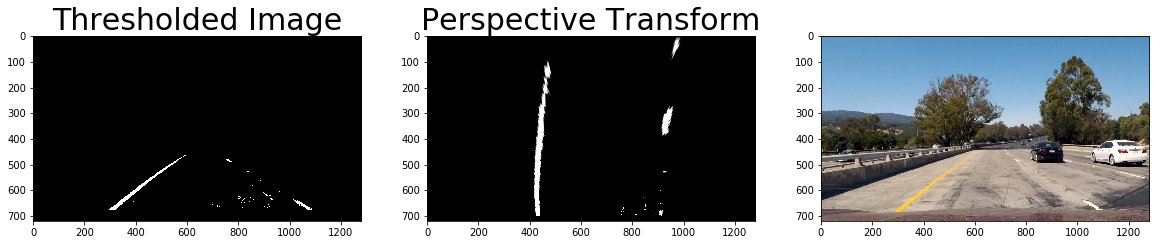

[(430, 899), (444, 899), (458, 914), (470, 920), (484, 928), (497, 928), (515, 947), (534, 951), (556, 951)]


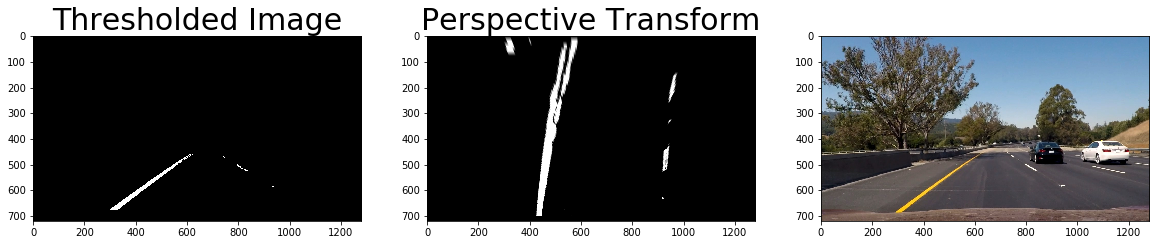

[(403, 873), (402, 876), (406, 881), (395, 884), (413, 884), (411, 884), (410, 885), (418, 885), (427, 884)]


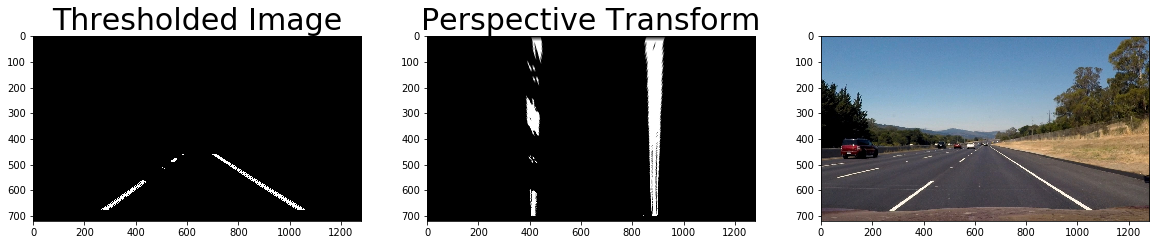

[(440, 907), (437, 907), (453, 914), (438, 916), (443, 916), (453, 936), (462, 936), (464, 957), (464, 963)]


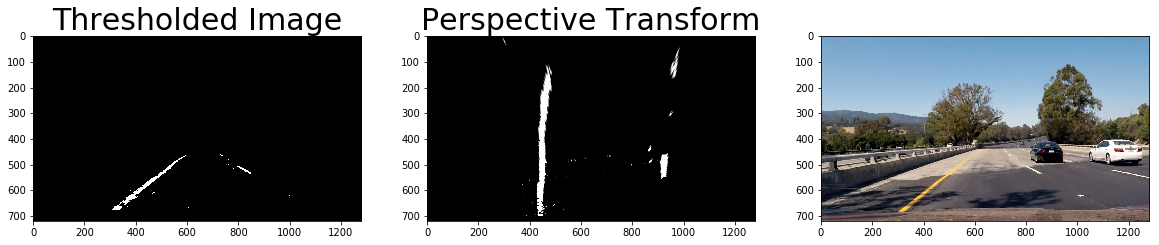

[(397, 889), (387, 898), (400, 898), (402, 908), (413, 926), (411, 933), (469, 937), (468, 937), (469, 964)]


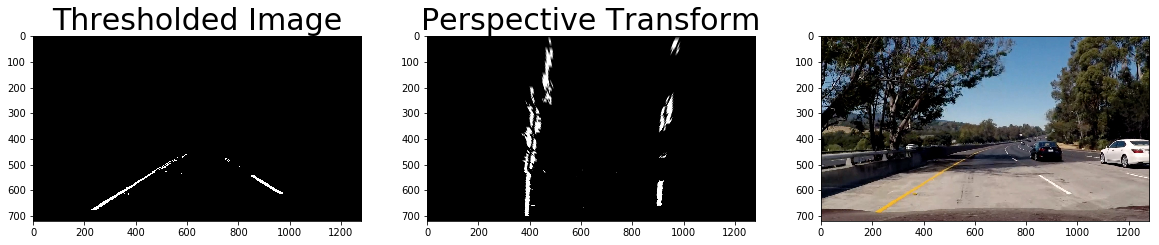

[(398, 871), (403, 874), (409, 874), (419, 875), (416, 877), (416, 870), (416, 863), (417, 871), (414, 885)]


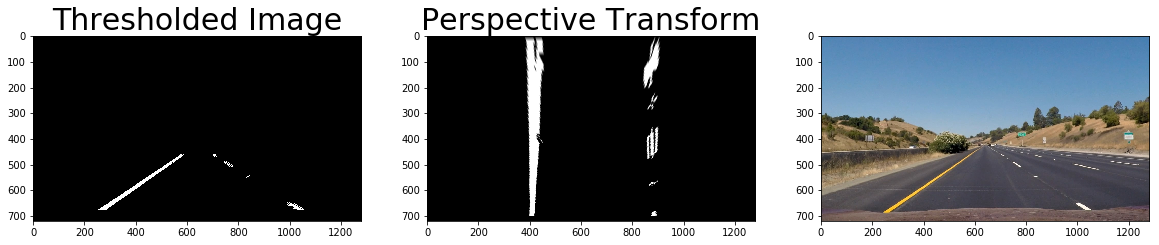

[(417, 894), (440, 899), (447, 907), (459, 914), (471, 927), (485, 936), (500, 936), (518, 957), (538, 964)]


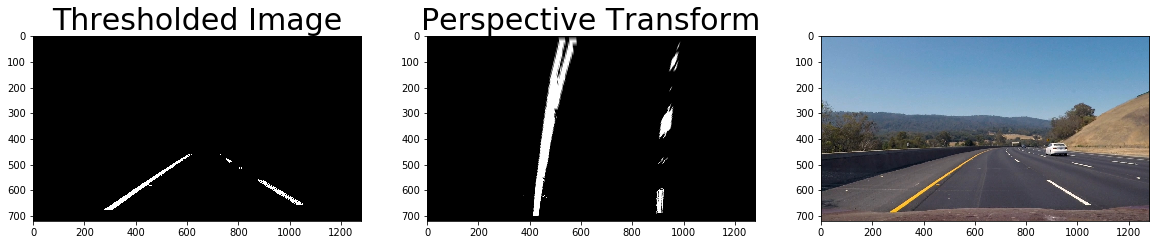

[(441, 900), (442, 900), (453, 912), (441, 907), (430, 905), (422, 888), (412, 845), (387, 860), (376, 862)]


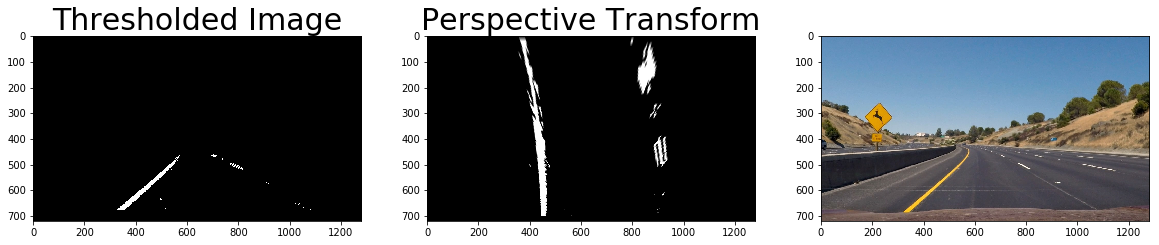

In [6]:
test_images = "./test_images/"
for image_link in os.listdir(test_images):
    image = mpimg.imread(test_images+image_link)
    advanced_lane_lines_pipline(image,cam,imageprocessor,lanefinder,True)